In [1]:
import numpy as np
import scipy as sp
import sys

sys.version


'3.3.5 |Anaconda 2.2.0 (64-bit)| (default, Sep  2 2014, 13:55:40) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [48]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import time

import ssm_timeSeries as ts  # my self-written time series overhead
import ssm_fit               # my self-written library for state-space model fitting

from IPython import display  # for live plotting

import random
from datetime import datetime     # generate random seed for 
random.seed(datetime.now())       # np.random. Once this is fixed, all 
rngSeed = random.randint(0, 1000) # other 'randomness' is also fixed

from scipy.io import savemat # store results for comparison with Matlab code

xDim = 3
yDim = 5

T = 100000
#obsScheme = {'subpops': [list(range(0,yDim)), list(range(0,yDim))],
#             'obsTime': [round(T/4), T],
#             'obsPops': [0, 1]}
subpops = [list(range(0,yDim)), list(range(0,yDim))]
obsTime = [int(round(T/4)), T]
obsPops = [0,1]
obsScheme = {'subpops': subpops,
             'obsTime': obsTime,
             'obsPops': obsPops}
[obsIdxG, idxgrps] = ssm_fit._computeObsIndexGroups(obsScheme,yDim)
obsScheme['obsIdxG'] = obsIdxG # add index groups and 
obsScheme['idxgrps'] = idxgrps # their occurences        

while True:
    W    = np.random.normal(size=[xDim,xDim])
    if np.abs(np.linalg.det(W)) > 0.001:
        break
A    = np.diag(np.linspace(0.3,0.8,xDim))  #np.diag(np.random.uniform(size=[xDim]))
A    = np.dot(np.dot(W, A), np.linalg.inv(W))
Q    = np.identity(xDim)
mu0  = np.random.normal(size=[xDim]) #np.random.normal(size=[xDim])
V0   = np.identity(xDim)
C = np.random.normal(size=[yDim, xDim])
R = np.identity(yDim)
R[0,0] = 9
R[1,1] = 1
R[2,2] = 4
R[3,3] = 7
d = np.random.normal(size=yDim)
d = 10 * np.arange(yDim)

uDim = 1
B = 1 + np.random.normal(size=[xDim,uDim])/25
B = 0 * B
u = np.ones([uDim, T, 1])
u[:,range(int(T/2)),0] = -1
u += np.random.normal(size=u.shape)

seq = ts.setStateSpaceModel('iLDS', [xDim,yDim,uDim], [A,B,Q,mu0,V0,C,d,R])  # initiate true model
seq.giveEmpirical().addData(1,T,[u],rngSeed)                                # draw toy data

# initiate parameters for analysis model
A_0   = np.diag(np.random.uniform(size=[xDim]))
Q_0   = 5*np.identity(xDim)              
mu0_0 = 5*np.random.normal(size=[xDim])   
V0_0  = 10*np.identity(xDim)               
C_0   = np.random.normal(size=[yDim,xDim]) 
d_0   = np.random.normal(size=yDim)          
R_0   = 10*np.identity(yDim)    
B_0   = 0 * np.random.normal(size=[xDim, uDim])


seq = ts.setStateSpaceModel('iLDS', [xDim,yDim,uDim], [A_0,B_0,Q_0,mu0_0,V0_0,C_0,d_0,R_0], seq) # adds analysis model 
model = seq.analysis1.giveModel()                                                     

# check implementation of E- and M- step by doing one such step each:
x = seq.giveEmpirical().giveData().giveTracesX()
y = seq._empirical._data.giveTracesY()                                             

no data model. Assuming data is given by real experiment or other external source
checking factorization of model ...
... factorization (locally) describes directed acyclic graph
no data model. Assuming data is given by real experiment or other external source
checking factorization of model ...
... factorization (locally) describes directed acyclic graph


LL_new - LL_old
-1612.25237146
WARNING! Lower bound decreased during EM algorithm. This is impossible for an LDS. Continue?
Press Y to continue or N to cancel
data log-likelihood for parameter initializations:
-7586047.62685
data log-likelihood for fitted parameters:
-1153943.39905
elapsed time for fitting is
483.6602876186371


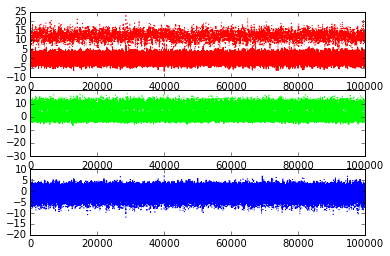

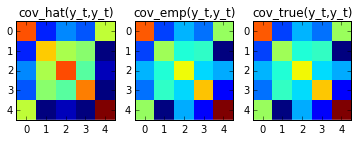

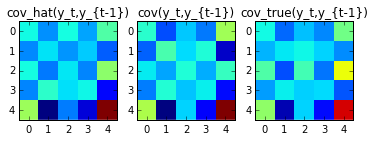

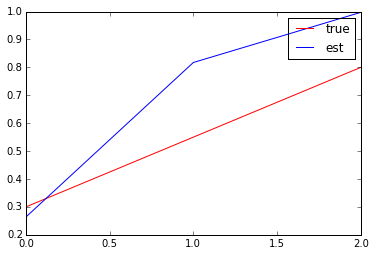

In [49]:
[Ext, Extxt, Extxtm1,LL0]    = ssm_fit._iLDS_E_step(A_0,B_0,Q_0,mu0_0,V0_0,C_0,d_0,R_0, 
                                                   y,u,obsScheme)    # do one E-step 
[A_1,B_1,Q_1,mu0_1,V0_1,C_1,d_1,R_1,my,syy,suu,suuinv,Ti] = ssm_fit._iLDS_M_step(Ext, 
                                                                                Extxt, 
                                                                                Extxtm1, 
                                                                                y, u,
                                                                                obsScheme) # do one M-step
[Ext1, Extxt1, Extxtm11,LL1] = ssm_fit._iLDS_E_step(A_1,B_1,Q_1,mu0_1,V0_1,C_1,d_1,R_1, 
                                                   y,u,obsScheme)   # do another E-step
[Ext_true, Extxt_true, Extxtm1_true, LLtr] = ssm_fit._iLDS_E_step(A,B,Q,mu0,V0,C,d,R,
                                                                 y,u,obsScheme)

t = time.time()
LLs = seq.analysis1.fitModel(20,           # maxIter                             
                             np.log(1.00001), # stop if likelihood change < 0.001%
                             None,
                             0, 
                             None, 
                             None,
                             obsScheme,
                             True,
                             True)
elapsedTime = time.time() - t
print('elapsed time for fitting is')
print(elapsedTime)
[A_h,B_h,Q_h,mu0_h,V0_h,C_h,d_h,R_h] = model.givePars().copy()

[Ext_h, Extxt_h, Extxtm1_h, LL_h]          = ssm_fit._iLDS_E_step(A_h,B_h,Q_h,mu0_h,V0_h,C_h,d_h,R_h, 
                                                                 y,u,obsScheme)


Pi_h    = np.array([sp.linalg.solve_discrete_lyapunov(A_h, Q_h)])[0,:,:]
Pi_t_h  = np.dot(A_h.transpose(), Pi_h)

Pi    = np.array([sp.linalg.solve_discrete_lyapunov(A, Q)])[0,:,:]
Pi_t  = np.dot(A.transpose(), Pi)

dataCov  = np.cov(y[:,0:T-1,0], y[:,1:T,0])
covyy    = dataCov[np.ix_(np.arange(0, yDim), np.arange(0,     yDim))]
covyy_m1 = dataCov[np.ix_(np.arange(0, yDim), np.arange(yDim,2*yDim))]

plt.figure(1)
cmap = matplotlib.cm.get_cmap('brg')
clrs = [cmap(i) for i in np.linspace(0, 1, xDim)]
for i in range(xDim):
    plt.subplot(xDim,1,i)
    plt.plot(x[i,:,0], color=clrs[i])
    plt.hold(True)
    if np.mean( np.square(x[i,:,0] - Ext_h[i,:,0]) ) < np.mean( np.square(x[i,:,0] + Ext_h[i,:,0]) ):
        plt.plot( Ext_h[i,:,0], color=clrs[i], ls=':')
    else:
        plt.plot(-Ext_h[i,:,0], color=clrs[i], ls=':')
m = covyy.min()
M = covyy.max()        
plt.figure(2)
plt.subplot(1,3,1)
plt.imshow(np.dot(np.dot(C_h, Pi_h), C_h.transpose()) + R_h, interpolation='none')
plt.title('cov_hat(y_t,y_t)')
plt.clim(m,M)
plt.subplot(1,3,2)
plt.imshow(covyy,    interpolation='none')
plt.title('cov_emp(y_t,y_t)')
plt.clim(m,M)
plt.subplot(1,3,3)
plt.imshow(np.dot(np.dot(C, Pi), C.transpose()) + R, interpolation='none')
plt.title('cov_true(y_t,y_t)')
plt.clim(m,M)
plt.figure(3)

m = covyy_m1.min()
M = covyy_m1.max()        
plt.subplot(1,3,1)
plt.imshow(np.dot(np.dot(C_h, Pi_t_h), C_h.transpose()), interpolation='none')
plt.title('cov_hat(y_t,y_{t-1})')
plt.clim(m,M)
plt.subplot(1,3,2)
plt.imshow(covyy_m1,    interpolation='none')
plt.title('cov(y_t,y_{t-1})')
plt.clim(m,M)
plt.subplot(1,3,3)
plt.imshow(np.dot(np.dot(C, Pi_t), C.transpose()), interpolation='none')
plt.title('cov_true(y_t,y_{t-1})')
plt.clim(m,M)
plt.figure(4)
plt.plot(np.sort(np.linalg.eig(A)[0]), 'r')
plt.hold(True)
plt.plot(np.sort(np.linalg.eig(A_h)[0]), 'b')
plt.legend(['true', 'est'])


matlabSaveFile = {'x': x, 'y': y, 'u' : u, 
                  'A':A, 'B':B, 'Q':Q, 'mu0':mu0,'V0':V0,'C':C,'d':d,'R':R,
                  'A_0':A_0, 'B_0':B_0, 'Q_0':Q_0, 'mu0_0':mu0_0,'V0_0':V0_0,'C_0':C_0,'d_0':d_0,'R_0':R_0,
                  'A_1':A_1, 'B_1':B_1, 'Q_1':Q_1, 'mu0_1':mu0_1,'V0_1':V0_1,'C_1':C_1,'d_1':d_1,'R_1':R_1,
                  #'A_h':A_h, 'Q_h':Q_h, 'mu0_h':mu0_h,'V0_h':V0_h,'C_h':C_h,'R_h':R_h,
                  'Ext':Ext, 'Extxt':Extxt, 'Extxtm1':Extxtm1,
                  'T':T,
                  'LL0': LL0, 'LL1': LL1}
savemat('LDS_data.mat',matlabSaveFile)



A_0
[[ 0.63987666  0.          0.        ]
 [ 0.          0.20667833  0.        ]
 [ 0.          0.          0.50943293]]
A
[[ 0.20045641 -0.14713823  0.41484248]
 [ 0.10740562  0.75412338 -0.15606139]
 [-0.10179321 -0.17963803  0.69542021]]
A_h
[[ 0.55751711  0.29458868 -0.31667096]
 [ 0.09212491  0.8581777   0.17684163]
 [-0.1570802   0.26016845  0.66298978]]
B_0
[[-0.]
 [ 0.]
 [-0.]]
B
[[ 0.]
 [ 0.]
 [ 0.]]
B_h
[[-0.00091151]
 [-0.00016375]
 [ 0.00014258]]
Q_0
[[ 5.  0.  0.]
 [ 0.  5.  0.]
 [ 0.  0.  5.]]
Q
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
Q_h
[[ 1.50807904  0.17155433 -0.05638752]
 [ 0.17155433  1.15705058 -0.29636296]
 [-0.05638752 -0.29636296  2.71429949]]


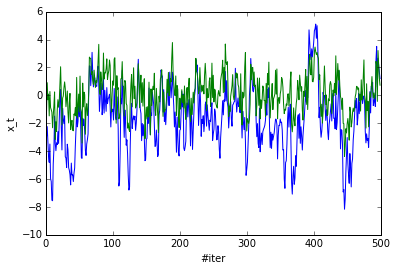

In [56]:
plotRange = range(2000, 2500)

#plt.plot(Ext_true[0,plotRange,0])
plt.plot(Ext_h[0,plotRange,0])
plt.plot(x[0,plotRange,0])
plt.xlabel('#iter')
plt.ylabel('x_t')
print('A_0')
print(A_0)
print('A')
print(A)
print('A_h')
print(A_h)
print('B_0')
print(B_0)
print('B')
print(B)
print('B_h')
print(B_h)
print('Q_0')
print(Q_0)
print('Q')
print(Q)
print('Q_h')
print(Q_h)

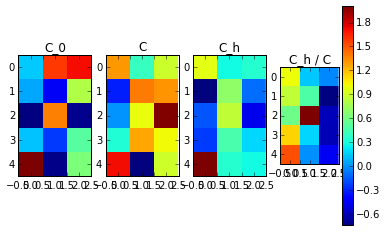

In [51]:
plt.subplot(1,4,1)
plt.title('C_0')
plt.imshow(C_0, interpolation='none')
plt.subplot(1,4,2)
plt.title('C')
plt.imshow(C, interpolation='none')
plt.subplot(1,4,3)
plt.title('C_h')
plt.imshow(C_h, interpolation='none')
plt.subplot(1,4,4)
plt.title('C_h / C')
plt.imshow(C_h / C, interpolation='none')
plt.colorbar()

[-1.21459891  1.15263363  0.65113948  0.06530558 -0.49337085]
[ 0 10 20 30 40]
[  0.40019946   8.21079535  18.00273226  28.72852115  42.63594069]


/home/mackelab/anaconda/envs/py3k/lib/python3.3/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: divide by zero encountered in true_divide


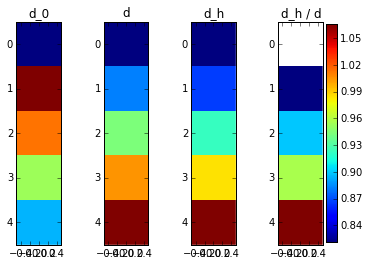

In [57]:
plt.subplot(1,4,1)
plt.title('d_0')
plt.imshow(d_0.reshape(yDim,1), interpolation='none')
plt.subplot(1,4,2)
plt.title('d')
plt.imshow(d.reshape(yDim,1), interpolation='none')
plt.subplot(1,4,3)
plt.title('d_h')
plt.imshow(d_h.reshape(yDim,1), interpolation='none')
plt.subplot(1,4,4)
plt.title('d_h / d')
plt.imshow((d_h / d).reshape(yDim,1), interpolation='none')
plt.colorbar()
print(d_0)
print(d)
print(d_h)

[[ 10.   0.   0.   0.   0.]
 [  0.  10.   0.   0.   0.]
 [  0.   0.  10.   0.   0.]
 [  0.   0.   0.  10.   0.]
 [  0.   0.   0.   0.  10.]]
[[ 9.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  4.  0.  0.]
 [ 0.  0.  0.  7.  0.]
 [ 0.  0.  0.  0.  1.]]
[[ 9.06092556  0.          0.          0.          0.        ]
 [ 0.          1.06146437  0.          0.          0.        ]
 [ 0.          0.          4.17023716  0.          0.        ]
 [ 0.          0.          0.          7.11511895  0.        ]
 [ 0.          0.          0.          0.          1.11365932]]


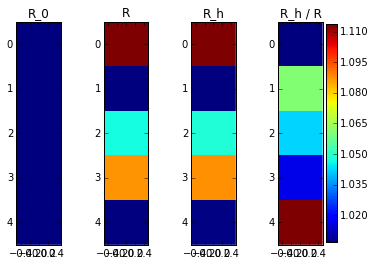

In [58]:
plt.subplot(1,4,1)
plt.title('R_0')
plt.imshow(R_0.diagonal().reshape(yDim,1), interpolation='none')
plt.subplot(1,4,2)
plt.title('R')
plt.imshow(R.diagonal().reshape(yDim,1), interpolation='none')
plt.subplot(1,4,3)
plt.title('R_h')
plt.imshow(R_h.diagonal().reshape(yDim,1), interpolation='none')
plt.subplot(1,4,4)
plt.title('R_h / R')
plt.imshow((R_h.diagonal() / R.diagonal()).reshape(yDim,1), interpolation='none')
plt.colorbar()
print(R_0)
print(R)
print(R_h)

In [59]:
Pi_h

array([[   9.07663404,   26.21118245,   15.31810449],
       [  26.21118245,  156.42594245,  108.0890132 ],
       [  15.31810449,  108.0890132 ,   81.1530804 ]])